In [256]:
import matplotlib.pyplot as plt
import numpy as np

Я взял оригинальный код с github и конветировал его в python:\
[Ссылка на код](https://github.com/tensorflow/playground/blob/master/src/dataset.ts)


In [257]:
class Example2D:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

In [258]:
def classify_two_gauss_data(num_samples, noise):
    points = []

    variance_scale = np.vectorize(lambda x: 0.5 + 3.5 * (x / 0.5))
    variance = variance_scale(noise)

    def gen_gauss(cx, cy, label):
        for _ in range(num_samples // 2):
            x = np.random.normal(cx, variance)
            y = np.random.normal(cy, variance)
            points.append(Example2D(x, y, label))

    gen_gauss(2, 2, 1)  # Gaussian with positive examples.
    gen_gauss(-2, -2, -1)  # Gaussian with negative examples.
    return points

In [259]:
def classify_spiral_data(num_samples, noise):
    points = []
    n = num_samples // 2

    def gen_spiral(delta_t, label):
        for i in range(n):
            r = i / n * 5
            t = 1.75 * i / n * 2 * np.pi + delta_t
            x = r * np.sin(t) + np.random.uniform(-1, 1) * noise
            y = r * np.cos(t) + np.random.uniform(-1, 1) * noise
            points.append(Example2D(x, y, label))

    gen_spiral(0, 1)  # Positive examples.
    gen_spiral(np.pi, -1)  # Negative examples.
    return points

In [260]:
def classify_xor_data(num_samples, noise):
    def get_xor_label(p):
        return 1 if p.x * p.y >= 0 else -1

    points = []
    for _ in range(num_samples):
        x = np.random.uniform(-5, 5)
        padding = 0.3
        x += padding if x > 0 else -padding  # Padding.
        y = np.random.uniform(-5, 5)
        y += padding if y > 0 else -padding
        noise_x = np.random.uniform(-5, 5) * noise
        noise_y = np.random.uniform(-5, 5) * noise
        label = get_xor_label(Example2D(x + noise_x, y + noise_y, None))
        points.append(Example2D(x, y, label))
    return points

In [261]:
def classify_circle_data(num_samples, noise):
    points = []
    radius = 5

    def get_circle_label(p, center):
        return 1 if np.linalg.norm([p.x - center.x, p.y - center.y]) < (radius * 0.5) else -1

    # Generate positive points inside the circle.
    for _ in range(num_samples // 2):
        r = np.random.uniform(0, radius * 0.5)
        angle = np.random.uniform(0, 2 * np.pi)
        x = r * np.sin(angle)
        y = r * np.cos(angle)
        noise_x = np.random.uniform(-radius, radius) * noise
        noise_y = np.random.uniform(-radius, radius) * noise
        label = get_circle_label(Example2D(x + noise_x, y + noise_y, None), Example2D(0, 0, None))
        points.append(Example2D(x, y, label))

    # Generate negative points outside the circle.
    for _ in range(num_samples // 2):
        r = np.random.uniform(radius * 0.7, radius)
        angle = np.random.uniform(0, 2 * np.pi)
        x = r * np.sin(angle)
        y = r * np.cos(angle)
        noise_x = np.random.uniform(-radius, radius) * noise
        noise_y = np.random.uniform(-radius, radius) * noise
        label = get_circle_label(Example2D(x + noise_x, y + noise_y, None), Example2D(0, 0, None))
        points.append(Example2D(x, y, label))
    return points

In [262]:
class DataGeneratorFactory:
    def __init__(self):
        self._factory_methods = {}

    def register(self, data_type, factory_method):
        self._factory_methods[data_type] = factory_method

    def create_generator(self, data_type, num_samples, noise):
        factory_method = self._factory_methods.get(data_type)
        if factory_method is None:
            raise ValueError(f"No factory method registered for data type: {data_type}")
        return factory_method(num_samples, noise)

In [263]:
df = DataGeneratorFactory()
df.register("gauss", classify_two_gauss_data)
df.register("circle", classify_circle_data)
df.register("xor", classify_xor_data)
df.register("spiral", classify_spiral_data)

In [264]:
import time
from functools import wraps

def measure_time(func):
    """
    Decorator to measure the execution time of a function.
    """

    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Function {func.__name__} took {execution_time:.2f} seconds to execute.")
        return result

    return wrapper

In [265]:
# mode is iterative or gradient

class Perceptron:
    def __init__(self, input_size, weights=None, bias=None,
                 activation=np.tanh, activation_derivative=lambda x: 1-np.tanh(x)**2, mode = 'gradient'):
        self.input_size = input_size
        self.weights = weights if weights is not None else np.zeros(input_size)
        self.bias = bias if bias is not None else np.random.rand()
        self.mode = mode
        self.activation = activation
        self.activation_derivative = activation_derivative


    def _step_function(self, x):
      r = np.copy(x)
      r[r >= 0] = 1.
      r[r < 0] = -1.
      return r

    def _weighted_sum(self, x):
        return np.dot(x, self.weights) + self.bias

    def predict(self, x):
      ws = self._weighted_sum(x)
      if self.mode == 'gradient':
        ws = self.activation(ws)
      return self._step_function(ws)

    def _train_iterative(self, X, y, learning_rate, epochs):
        for _ in range(epochs):
            for i in range(len(X)):
                x = X[i]
                y_true = y[i]

                y_pred = self.predict(x)

                delta = y_true - y_pred

                self.weights += learning_rate * delta * x
                self.bias += learning_rate * delta

    def _train_gradient(self, X, y, learning_rate, epochs):
        for _ in range(epochs):
            for i in range(len(X)):
                x = X[i]
                y_true = y[i]
                ws = self._weighted_sum(x)
                y_pred = self.activation(ws)

                # print(f"loss: {0.5 * (y_pred - y_true)**2}")

                #loss = Square error loss
                loss_derivative = y_pred - y_true
                activation_derivative = self.activation_derivative(ws)
                learn_k = learning_rate * loss_derivative * activation_derivative

                self.weights -= learn_k * x
                self.bias -= learn_k
    @measure_time
    def train(self, X, y, learning_rate=0.1, epochs=100):
      if self.mode == 'gradient':
        return self._train_gradient(X,y,learning_rate, epochs)
      else:
        return self._train_iterative(X,y,learning_rate, epochs)


In [266]:
from concurrent.futures import ThreadPoolExecutor

class PerceptronEnsemble:
    def __init__(self, n_estimators, input_size, mode = 'gradient'):
        self.estimators = [Perceptron(input_size, mode = mode) for _ in range(n_estimators)]

    @measure_time
    def fit(self, X, y, learning_rate=0.1, epochs=100, n_threads=4):
        with ThreadPoolExecutor(max_workers=n_threads) as executor:
            futures = []
            for estimator in self.estimators:
                # Sample with replacement for bagging
                indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
                X_subset, y_subset = X[indices], y[indices]

                # Submit training task with bagged data to the thread pool
                futures.append(executor.submit(estimator.train, X_subset, y_subset, learning_rate, epochs))

            # Wait for all tasks to complete
            for future in futures:
                future.result()

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.estimators)))
        for i, estimator in enumerate(self.estimators):
            predictions[:, i] = estimator.predict(X)
        return np.sign(np.sum(predictions, axis=1))  # Majority voting

In [267]:
def confusion_matrix(y_true, y_pred):
    # Initialize confusion matrix (2x2 for binary classification)
    cm = np.zeros((2, 2), dtype=int)

    # Populate the matrix
    for i in range(len(y_true)):
        true_class = 0 if y_true[i] == -1 else 1  # Map -1 to index 0, 1 to index 1
        pred_class = 0 if y_pred[i] == -1 else 1
        cm[true_class, pred_class] += 1

    return cm

In [331]:
def draw_data(data, ensemble):
    plt.figure(figsize=(8, 6))
    plt.xlim((-8,8))
    plt.ylim((-8,8))
    # Extract positive and negative points using list comprehensions
    x_positive = [point.x for point in data if point.label == 1]
    y_positive = [point.y for point in data if point.label == 1]
    x_negative = [point.x for point in data if point.label == -1]
    y_negative = [point.y for point in data if point.label == -1]

    plt.scatter(x_positive, y_positive, c='b', label='Positive examples')
    plt.scatter(x_negative, y_negative, c='r', label='Negative examples')

    # Plot decision boundaries for each Perceptron
    for i, estimator in enumerate(ensemble.estimators):
        w0 = estimator.bias
        w1, w2 = estimator.weights  # Assuming weights are accessible
        x1 = np.linspace(min(point.x for point in data), max(point.x for point in data), 100)
        x2 = -(w0 + w1 * x1) / w2  # Solve for x2 from the equation

        plt.plot(x1, x2, label=f"Perceptron {i+1}")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Data and Decision Boundaries")
    plt.legend()
    plt.grid(True)
    plt.show()

In [341]:
ensemble_n = 5
input_size = 2
mode = 'gradient'

dataset_size = 500
noise = 0.2
datatype = "spiral"
learning_rate = 0.03
epochs = 10

In [342]:
d = df.create_generator(datatype, dataset_size, noise)
X = np.array([[p.x,p.y] for p in d])
y = np.array([p.label for p in d])

In [343]:
ensemble = PerceptronEnsemble(ensemble_n, input_size, mode)
ensemble.fit(
    X = X,
    y = y,
    epochs = epochs,
    learning_rate = learning_rate
)

Function train took 0.22 seconds to execute.
Function train took 0.30 seconds to execute.
Function train took 0.35 seconds to execute.
Function train took 0.36 seconds to execute.
Function train took 0.12 seconds to execute.
Function fit took 0.43 seconds to execute.


In [344]:
y_pred = ensemble.predict(X)
cm = confusion_matrix(
    y_true = y,
    y_pred = y_pred
)
print(cm)

[[193  57]
 [150 100]]


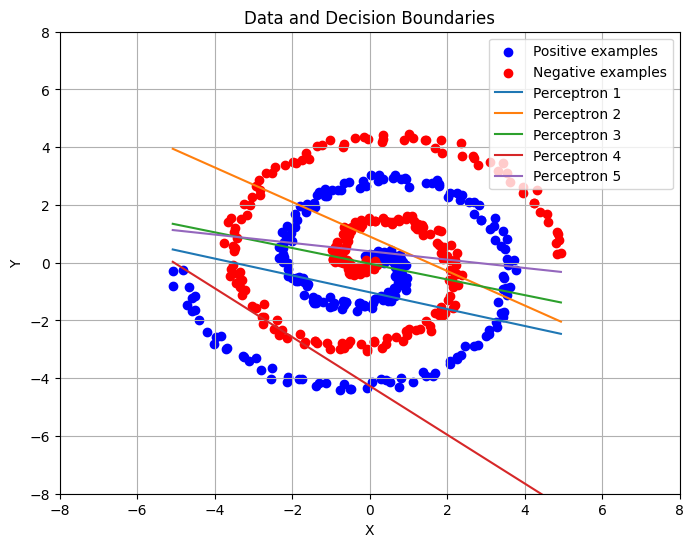

In [345]:
draw_data(
    data = d,
    ensemble = ensemble
)